In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap
from IPython.display import clear_output, display

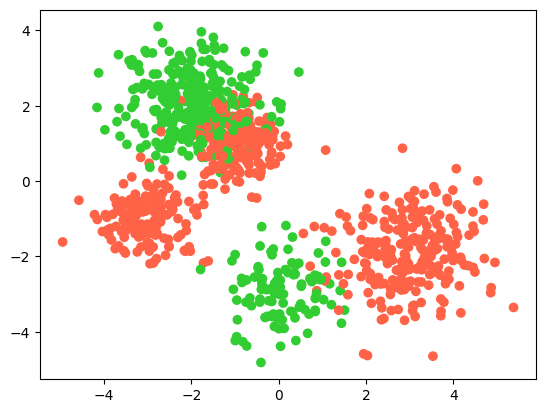

In [2]:
X, y = make_blobs(
    n_samples=[150, 300, 200, 100, 250],
    centers=[[-3, -1], [-2, 2], [-1, 1], [0, -3], [3, -2]],
    cluster_std=[0.6, 0.8, 0.5, 0.7, 0.9],
    random_state=42
)
y = np.where((y == 1) | (y == 3), 0, 1)

colors = ('limegreen', 'tomato')
C = [colors[1] if label else colors[0] for label in y]

plt.scatter(X[:, 0], X[:, 1], c=C)
plt.show()

In [3]:
X_train = torch.FloatTensor(X)
y_train = torch.FloatTensor(y).view(-1, 1)
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=64, shuffle=True)

In [4]:
def train(model, loader, criterion, optimizer, num_epoch):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    history, frames = [], []
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    eps = 0.1
    xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 100),
            np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 100))
    mesh_data = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)

    for epoch in range(num_epoch + 1):
        model.train()
        epoch_loss = []
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())

        history.append(np.mean(epoch_loss))
        Z = model(mesh_data).cpu().detach().numpy().reshape(xx.shape)
        Z = (Z > 0.5).astype(int)
        frames.append(Z.copy())

        if epoch % 25 == 0:
            model.eval()
            with torch.no_grad():
                ax1.clear()
                ax1.pcolormesh(xx, yy, frames[-1], cmap=ListedColormap(colors), alpha=0.3)
                ax1.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(colors))

                ax2.clear()
                ax2.plot(range(1, epoch + 2), history)
                ax2.grid(True)

                display(plt.gcf())
                clear_output(wait=True)

    return history, frames

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x
    
    def intermediate(self, x):
        return F.sigmoid(self.fc1(x))

In [6]:
summary(Net(), input_size=(1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 5]              15
            Linear-2                 [-1, 1, 1]               6
Total params: 21
Trainable params: 21
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [7]:
model = Net()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

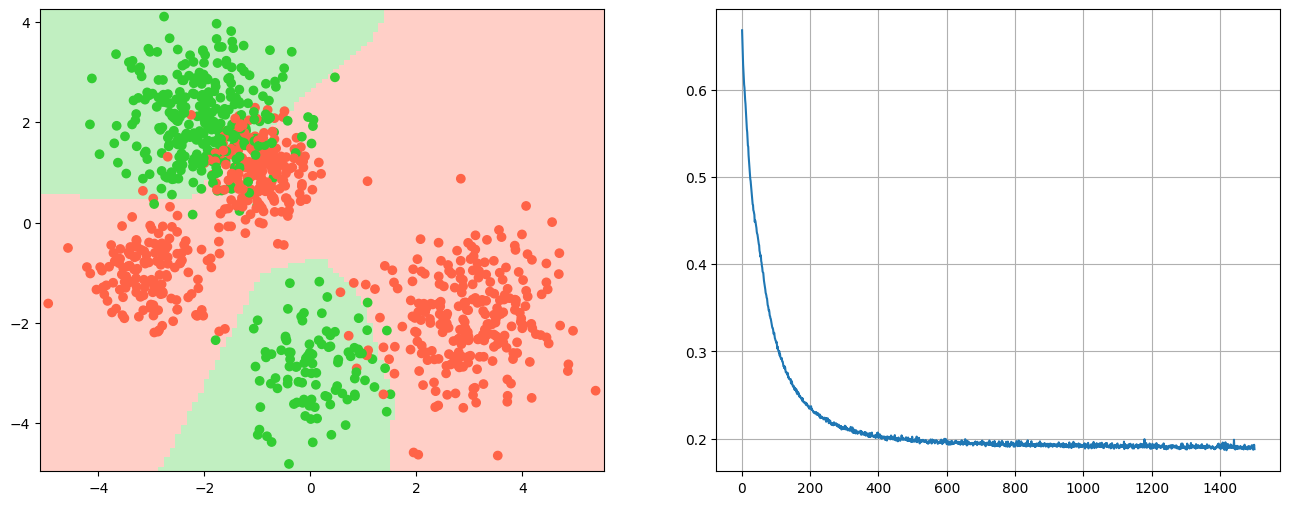

In [8]:
history, frames = train(model, train_loader, criterion, optimizer, 1500)

bias = -3.312


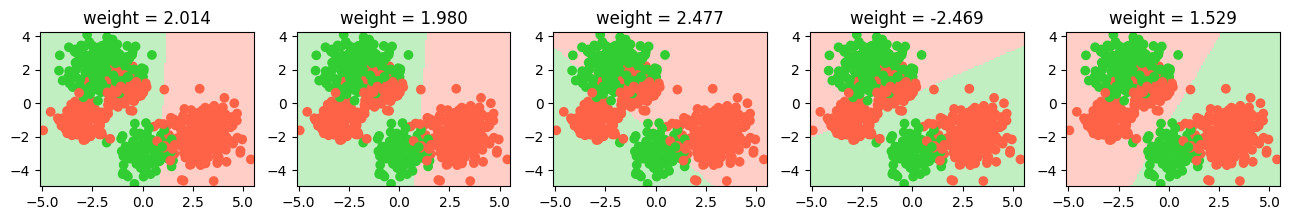

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 2))
eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 100),
        np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 100))
mesh_data = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)

print(f"bias = {model.fc2.bias.item():.3f}")
model.eval()
with torch.no_grad():
    Z = model.intermediate(mesh_data).cpu().detach().numpy()
    for i, ax in enumerate((ax1, ax2, ax3, ax4, ax5)):
        ax.pcolormesh(xx, yy, (Z[:, i] > 0.5).reshape(xx.shape).astype(int), cmap=ListedColormap(colors), alpha=0.3)
        ax.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(colors))
        ax.set_title(f"weight = {model.fc2.weight[0, i].item():.3f}")
plt.show()

In [57]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 100),
        np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 100))
frames_ = frames[:39] + [frames[39 + 10 * i] for i in range(27)]

def animate(i):
    ax.clear()
    ax.pcolormesh(xx, yy, frames_[i], cmap=ListedColormap(colors), alpha=0.3)
    ax.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(colors))
    return ax

anim = FuncAnimation(fig, animate, frames=len(frames_))
anim.save('training.gif', writer='pillow', fps=10)
plt.close()